In [ ]:
# import relevant libraries 
import io
import pandas as pd
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.tree import export_graphviz
import pydot


In [ ]:
# Get python version
!python --version

# Get sklearn version
print(sklearn.__version__)


Python 3.7.11
0.22.2.post1


In [ ]:
uploaded = files.upload()

Saving credit_line_increase.csv to credit_line_increase.csv


In [ ]:
# read uploaded data file into a pandas dataframe
data = pd.read_csv(io.BytesIO(uploaded['credit_line_increase.csv']))

# Determine the names of the columns 
number_of_cols = 0
for col in data.columns:
    print(col)
    number_of_cols = number_of_cols + 1

print("There are", number_of_cols, "number of columns")

ID
LIMIT_BAL
SEX
RACE
EDUCATION
MARRIAGE
AGE
PAY_0
PAY_2
PAY_3
PAY_4
PAY_5
PAY_6
BILL_AMT1
BILL_AMT2
BILL_AMT3
BILL_AMT4
BILL_AMT5
BILL_AMT6
PAY_AMT1
PAY_AMT2
PAY_AMT3
PAY_AMT4
PAY_AMT5
PAY_AMT6
DELINQ_NEXT
There are 26 number of columns


In [ ]:
data.isnull().sum()

ID             0
LIMIT_BAL      0
SEX            0
RACE           0
EDUCATION      0
MARRIAGE       0
AGE            0
PAY_0          0
PAY_2          0
PAY_3          0
PAY_4          0
PAY_5          0
PAY_6          0
BILL_AMT1      0
BILL_AMT2      0
BILL_AMT3      0
BILL_AMT4      0
BILL_AMT5      0
BILL_AMT6      0
PAY_AMT1       0
PAY_AMT2       0
PAY_AMT3       0
PAY_AMT4       0
PAY_AMT5       0
PAY_AMT6       0
DELINQ_NEXT    0
dtype: int64

In [ ]:
# Calculate basic descriptive statistics for the data
data.describe()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,2.721967,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,1.094397,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,2.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,3.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,4.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [ ]:
# Define x and y variables for the model
y_name = 'DELINQ_NEXT'
X_names = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Split the data into training, validation and testing data
train_X, valid_test_X, train_y, valid_test_y = train_test_split(data[X_names], data[y_name], test_size=0.5, random_state=122333) # split off training data
valid_X, test_X, valid_y, test_y = train_test_split(valid_test_X, valid_test_y, test_size=0.5, random_state=333221) # split remainder into validation and test

# delete validation and testing data combination to avoid contamination 
del valid_test_X 
del valid_test_y

# Get the train, valid and test split composition
print('Training data: %i rows and %i columns' % (train_X.shape[0], train_X.shape[1] + 1 ))
print('Validation data: %i rows and %i columns' % (valid_X.shape[0], valid_X.shape[1] + 1))
print('Testing data: %i rows and %i columns' % (test_X.shape[0], test_X.shape[1] + 1))

Training data: 15000 rows and 20 columns
Validation data: 7500 rows and 20 columns
Testing data: 7500 rows and 20 columns


In [ ]:
# Define the max depth of the decision tree
max_depth = 12
candidate_models = {}

for depth in range(0, max_depth):

  # Develop a classifier for modeling
  clf = RandomForestClassifier(max_depth = depth + 1, random_state=12345)
  # Fit the model 
  clf.fit(train_X, train_y)

  # Score the validation and training data
  train_phat = clf.predict_proba(train_X)[:, 1]
  valid_phat = clf.predict_proba(valid_X)[:, 1]

  # Calculate Area under the curve to determine perfomance quality
  train_auc = roc_auc_score(train_y, train_phat)
  valid_auc = roc_auc_score(valid_y, valid_phat)

  # Check cross validation scores for stability testing
  cv_scores = cross_val_score(clf, valid_X, valid_y, scoring="roc_auc", cv=5)
  cv_std = np.std(cv_scores)

  # store the results to analyze the model at each level and then identify the best fit
  candidate_models[depth + 1] = {}
  candidate_models[depth + 1]['Model'] = clf
  candidate_models[depth + 1]['Training AUC'] = train_auc
  candidate_models[depth + 1]['Validation AUC'] = valid_auc
  candidate_models[depth + 1]['5-Fold SD'] = cv_std


Text(0, 0.5, 'AUC')

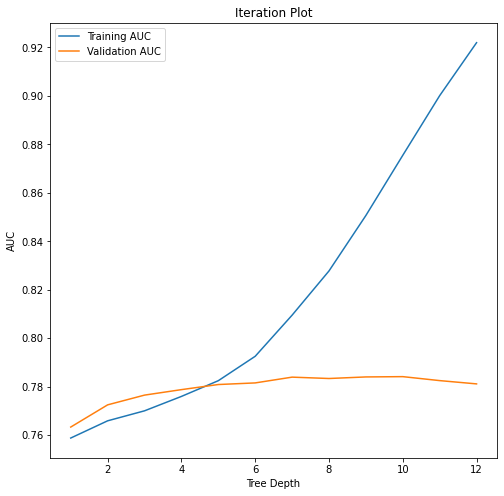

In [ ]:
candidate_results = pd.DataFrame.from_dict(candidate_models, orient='index')
fig,ax = plt.subplots(figsize=(8,8)) 
candidate_results[['Training AUC', 'Validation AUC']].plot(title='Iteration Plot', ax=ax)
ax.set_xlabel('Tree Depth')
ax.set_ylabel('AUC')

In [ ]:
candidate_results.iloc[:,1:]


,Training AUC,Validation AUC,5-Fold SD
1,0.758757,0.763289,0.011726
2,0.765866,0.772456,0.012494
3,0.769991,0.776476,0.012842
4,0.775936,0.778737,0.012928
5,0.782431,0.780848,0.012361
6,0.792508,0.781513,0.010849
7,0.809484,0.783897,0.011226
8,0.827738,0.783334,0.010791
9,0.850637,0.783980,0.010888
10,0.875483,0.784103,0.009690


In [ ]:
test_phat = candidate_models[6]['Model'].predict_proba(test_X)[:, 1]
print('Test AUC: %.4f' % roc_auc_score(test_y, test_phat))

Test AUC: 0.7743


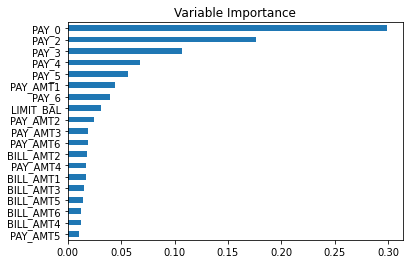

In [ ]:
# get variable importances
# Rank each variable of the model by how important it is in the model
best_model = candidate_models[6]['Model']
importances = pd.DataFrame(best_model.feature_importances_,
                           index=X_names,
                           columns=['Importance'])

importances.sort_values(by='Importance').plot(kind='barh', title='Variable Importance', legend=False)

In [ ]:
# score the best model on test data to get an honest performance assessment
# Test Error

test_phat = best_model.predict_proba(test_X)[:, 1]
print('Test AUC: %.4f' % roc_auc_score(test_y, test_phat))

Test AUC: 0.7743


In [ ]:
# create confusion matrix

def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    frame_ = frame.copy(deep=True)

    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]

    # output
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame


In [ ]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    eps = 1e-20

    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1])
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) 
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    return ((protected_prop + eps)/(reference_prop + eps))

In [ ]:
# add probabilities onto validation set

# add back race and sex markers
# compare results according to phat
valid_yhat = pd.DataFrame(valid_X, columns=X_names)
valid_yhat['RACE'] = data.loc[valid_yhat.index, 'RACE']
valid_yhat['SEX'] = data.loc[valid_yhat.index, 'SEX']
valid_yhat[y_name] = valid_y
valid_yhat['phat'] = best_model.predict_proba(valid_X)[:, 1]
valid_yhat.head()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,RACE,SEX,DELINQ_NEXT,phat
10851,140000,-2,-2,-2,-2,-2,-2,700,700,700,3105,1259,700,700,700,3105,1259,700,700,4.0,1,0,0.143113
15737,400000,-1,-1,-1,0,-1,-1,20030,3497,6725,6016,8985,14705,3513,6742,1435,9030,14778,25730,3.0,2,0,0.089723
18147,340000,0,0,0,0,0,0,85292,66486,62918,53322,50180,57000,17241,16000,13322,10005,9081,9080,3.0,1,0,0.079146
14940,50000,0,0,0,0,0,0,25330,25894,26866,26673,26871,27009,1745,1717,914,1000,963,1112,4.0,1,0,0.155906
19824,20000,3,3,2,0,0,0,10145,9836,10525,18930,19320,19861,0,1000,9000,1000,1000,400,3.0,2,1,0.601833


In [ ]:
# calculate confusion matrices across race groups

# Define a dict holding race key-pairs
race_dict = {'hispanic' : 1,
             'black' : 2,
             'white' : 3,
             'asian' : 4}

race_group_names = list(race_dict.keys())
race_cm_dict = {}

# calculate confusion matrices at standard cutoff 0.15
for name in race_group_names:
    race_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=race_dict[name], cutoff=0.15)
    print(race_cm_dict[name])
    print('(%s)' % name.title())
    print()

# calculate AIR
for name in race_group_names:
   if name != 'white':
      print('%s-to-%s AIR: %.2f' % (name, 'white', air(race_cm_dict, 'white', name)))
      print()
    


Confusion matrix by RACE=1
             actual: 1 actual: 0
predicted: 1       499       379
predicted: 0       107       481
(Hispanic)

Confusion matrix by RACE=2
             actual: 1 actual: 0
predicted: 1       489       375
predicted: 0       133       490
(Black)

Confusion matrix by RACE=3
             actual: 1 actual: 0
predicted: 1       225       914
predicted: 0        50      1116
(White)

Confusion matrix by RACE=4
             actual: 1 actual: 0
predicted: 1       196       904
predicted: 0        45      1097
(Asian)

White proportion accepted: 0.506
Hispanic proportion accepted: 0.401
hispanic-to-white AIR: 0.79

White proportion accepted: 0.506
Black proportion accepted: 0.419
black-to-white AIR: 0.83

White proportion accepted: 0.506
Asian proportion accepted: 0.509
asian-to-white AIR: 1.01



In [ ]:
# Sex bias testing

# calculate confusion matrices across sex groups

# calculate AIR
sex_dict = {'male': 1,
            'female': 2}

sex_group_names = list(sex_dict.keys())
sex_cm_dict = {}

# confusion matrices at 0.15
for name in sex_group_names:
    sex_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='SEX', level=sex_dict[name], cutoff=0.15)
    print(sex_cm_dict[name])
    print('(%s)' % name.title())
    print()

# calculate AIR
for name in sex_group_names:
   if name != 'male':
      print('%s-to-%s AIR: %.2f' % (name, 'male', air(sex_cm_dict, 'male', name)))
      print()


Confusion matrix by SEX=1
             actual: 1 actual: 0
predicted: 1       628      1046
predicted: 0       134      1192
(Male)

Confusion matrix by SEX=2
             actual: 1 actual: 0
predicted: 1       781      1526
predicted: 0       201      1992
(Female)

Male proportion accepted: 0.442
Female proportion accepted: 0.487
female-to-male AIR: 1.10



Bias Remediation

In [ ]:
# function to calculate accurarcy at a certain probability cutoff
def get_acc(frame, cutoff, y_name, yhat_name):

  temp = frame.copy(deep=True) 
  temp['decision'] = np.where(temp[yhat_name] > cutoff , 1, 0)
  acc = accuracy_score(temp[y_name], temp['decision'])
  del temp
  return acc


In [ ]:
# Get accuracy of the model as you increase the cutoff
# higher cutoff = higher lending amount = more risk

for cutoff in np.arange(0.1, 0.31, 0.01):
  print('Accuracy at cutoff %.2f is: %.4f' % (np.round(cutoff, 2), 
                                              get_acc(valid_yhat, np.round(cutoff, 2), y_name, 'phat')))   


Accuracy at cutoff 0.10 is: 0.4104
Accuracy at cutoff 0.11 is: 0.4567
Accuracy at cutoff 0.12 is: 0.4935
Accuracy at cutoff 0.13 is: 0.5345
Accuracy at cutoff 0.14 is: 0.5743
Accuracy at cutoff 0.15 is: 0.6124
Accuracy at cutoff 0.16 is: 0.6563
Accuracy at cutoff 0.17 is: 0.6937
Accuracy at cutoff 0.18 is: 0.7232
Accuracy at cutoff 0.19 is: 0.7387
Accuracy at cutoff 0.20 is: 0.7525
Accuracy at cutoff 0.21 is: 0.7633
Accuracy at cutoff 0.22 is: 0.7705
Accuracy at cutoff 0.23 is: 0.7776
Accuracy at cutoff 0.24 is: 0.7835
Accuracy at cutoff 0.25 is: 0.7889
Accuracy at cutoff 0.26 is: 0.7920
Accuracy at cutoff 0.27 is: 0.7952
Accuracy at cutoff 0.28 is: 0.7971
Accuracy at cutoff 0.29 is: 0.8037
Accuracy at cutoff 0.30 is: 0.8059


In [ ]:
# recalculate AIR and confusion matrices at different new cutoff = 0.18
for name in race_group_names:
    race_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=race_dict[name], cutoff=0.18, verbose=False)

for name in race_group_names:
   if name != 'white':
      print('%s-to-%s AIR: %.2f' % (name, 'white', air(race_cm_dict, 'white', name)))
      print()

for name in sex_group_names:
    sex_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='SEX', level=sex_dict[name], cutoff=0.18, verbose=False)

for name in sex_group_names:
   if name != 'male':
      print('%s-to-%s AIR: %.2f' % (name, 'male', air(sex_cm_dict, 'male', name)))
      print()



White proportion accepted: 0.679
Hispanic proportion accepted: 0.548
hispanic-to-white AIR: 0.81

White proportion accepted: 0.679
Black proportion accepted: 0.560
black-to-white AIR: 0.82

White proportion accepted: 0.679
Asian proportion accepted: 0.677
asian-to-white AIR: 1.00

Male proportion accepted: 0.613
Female proportion accepted: 0.640
female-to-male AIR: 1.04



In [ ]:
# Train a new model trying to fix hispanic-to-white AIR

max_depth = 12
candidate_models = {}

for depth in range(0, max_depth):

  # Develop a classifier for modeling
  clf = RandomForestClassifier(max_depth = depth + 1, random_state=12345)
  # Fit the model 
  clf.fit(train_X, train_y)

  train_phat = clf.predict_proba(train_X)[:, 1]
  valid_phat = clf.predict_proba(valid_X)[:, 1]

  train_auc = roc_auc_score(train_y, train_phat)
  valid_auc = roc_auc_score(valid_y, valid_phat)

  valid_yhat = pd.DataFrame(valid_X, columns=X_names)
  valid_yhat['RACE'] = data.loc[valid_yhat.index, 'RACE']
  valid_yhat[y_name] = valid_y
  valid_yhat['phat'] = valid_phat
  cm_dict = {}
  cm_dict['white'] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=3, cutoff=0.18, verbose=False)
  cm_dict['hispanic'] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=1, cutoff=0.18, verbose=False)
  valid_hispanic_air = air(cm_dict, 'white', 'hispanic', verbose=False)

  cv_scores = cross_val_score(clf, valid_X, valid_y, scoring='roc_auc', cv=5)
  cv_std = np.std(cv_scores)

  candidate_models[depth + 1] = {}
  candidate_models[depth + 1]['Model'] = clf
  candidate_models[depth + 1]['Training AUC'] = train_auc
  candidate_models[depth + 1]['Validation AUC'] = valid_auc
  candidate_models[depth + 1]['5-Fold SD'] = cv_std
  candidate_models[depth + 1]['Hispanic-to-White AIR'] = valid_hispanic_air


Text(0, 0.5, 'AUC')

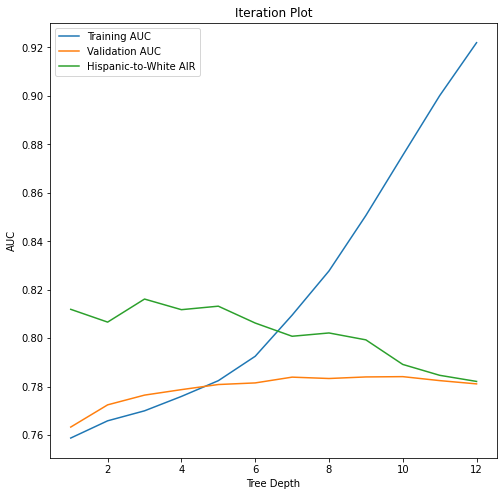

In [ ]:
candidate_results = pd.DataFrame.from_dict(candidate_models, orient='index')
fig, ax = plt.subplots(figsize=(8, 8))
candidate_results[['Training AUC', 'Validation AUC', 'Hispanic-to-White AIR']].plot(title='Iteration Plot',
                                                                                        ax=ax)
ax.set_xlabel('Tree Depth')
ax.set_ylabel('AUC')

In [ ]:
candidate_results.iloc[:,1:]


,Training AUC,Validation AUC,5-Fold SD,Hispanic-to-White AIR
1,0.758757,0.763289,0.011726,0.811893
2,0.765866,0.772456,0.012494,0.806618
3,0.769991,0.776476,0.012842,0.816135
4,0.775936,0.778737,0.012928,0.811748
5,0.782431,0.780848,0.012361,0.813191
6,0.792508,0.781513,0.010849,0.806233
7,0.809484,0.783897,0.011226,0.800777
8,0.827738,0.783334,0.010791,0.802136
9,0.850637,0.783980,0.010888,0.799289
10,0.875483,0.784103,0.009690,0.789142


Training AUC: 0.792508

Validation AUC: 0.781513

Test AUC: 0.7743

Asian-to-White AIR: 1.00

Black-to-White AIR: 0.82

Hispanic-to-White AIR:0.81

Female-to-Male AIR:1.04

		